## Red U-Net para la segmentación del iris

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans
import shutil

from skimage import data

In [70]:
# from keras.models import load_model

# model = load_model('Iris_unet_d5.h5')
# model.summary()

In [71]:
def create_segmented_dir(path_dataset, samples):
    '''
    Crea la mimsma estructura con la que cuenta el dataset de CASIA en la que se guardará 
    las imágenes segmentadas.
    '''
    # creamos carpeta en la que guardaremos las imágenes
    os.mkdir(path_dataset)
    for i in range(1, samples+1): # 108 sujetos
        sample = path_dataset + os.sep + "%.3d" % i
        os.mkdir(sample)
        for j in range(1,3): # 2 sesiones
            session = sample + os.sep + str(j)
            os.mkdir(session)
    print("-> Estructura de directorios creados satisfactoriamente.")
    

def copy_all_samples(path_samples, destination_directory):
    '''
    Copia todas las muestras del dataset de CASIA a un único directorio.
    '''
    os.mkdir(destination_directory)
        
    for root, dirs, files in os.walk(path_samples):
        for file in files:
            path_file = os.path.join(root,file)
            shutil.copy2(path_file,destination_directory)   
    print("-> Muestras copiadas satisfactoriamente.")

In [72]:
# ejecutar una única vez
# create_segmented_dir('CASIA-IrisV1-Segmented', 108)
# copy_all_samples('CASIA-IrisV1', 'dataset')

In [73]:
def testGenerator(directory,num_image,target_size = (320,320),flag_multi_class = False):
    '''
    Genera las muestras que se le pasarán al método predecir de la red preentrenada.
    
    Parámetros:
    directory -- directorio dónde se encuentran las muestras a generar
    num_image -- número máximo de imágenes que queremos generar
    target_size -- shape de de la muestra
    flag_multi_class -- (de momento mantener pero no nos es útil)
    '''
    i = 0
    for root, dirs, files in os.walk(directory):
        if files: # si es directorio hoja
            for file in files:
                if i == num_image:
                    break # sólo queremos x imágenes para probar
                path_file = os.path.join(root,file)
                img = cv2.imread(path_file,0)
                img = img / 255
                img = trans.resize(img,target_size)
                img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
                img = np.reshape(img,(1,)+img.shape)
                i += 1
                yield img

def get_samples_names(directory):
    '''
    Devuelve los nombres de las muestras(los que se encuentran en los directorios hoja)
    
    Parámetros:
    directory -- directorio de cuyos subdirectorios hoja se quiere el nombre 
    '''
    names = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            names.append(str(file))
            
    return names

def saveResult(save_path, name_path,npyfile,flag_multi_class = False):
    '''
    Guarda los imágenes segmentadas resultado de la red preentrenada
    
    Parámetros:
    save_path -- ruta en la que se guardarán las muestras segmentadas
    name_path -- directorio del que cogeremos los nombres de las muestras
    npyfile -- resultado de la red preentrenada
    flag_multi_class -- (de momento mantener pero no nos es útil)
    '''
    dim = (320, 280) # dimensioned de las muestras del dataset
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
        names = get_samples_names(name_path)
    #     for item, name in zip(npyfile, names):
    #         img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
    #         cv2.imwrite(os.path.join(save_path,name),img) # con cv2 da problemas
        for i,item in enumerate(npyfile):
            img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            io.imsave(os.path.join(save_path,names[i]),img)

In [74]:
# testGene = testGenerator("CASIA-IrisV1", 10) #len(os.listdir('dataset')))
# results = model.predict(testGene,15,verbose=1)
# saveResult("CASIA_Segmented","CASIA-IrisV1",results)

In [75]:
# img = results[0][:,:,0]
# plt.imshow(img, cmap='gray');

La segmentación se ha realizado correctamente, los únicos inconvenientes que aparecen puede ser que los bordes límbico y pupilar no aparecen bien definidos(están pixelados), y aparte cómo en el método `testGenerator` se cambió la resolución de la imagen a una cuadrada de 320x320, se aprecia que tanto la pupila como el iris están ovalados.

Sin embargo en el método `saveResult` se corrige el problema de la resolución, ya que volvemos a redimensionar la muestra segmentada para que cuente con las mismas dimensiones que las muestras originales.

Vamos a superponer la muestra segmentada sobre la muestra completa del ojo para comprobar que ha aislado correctamente el iris.

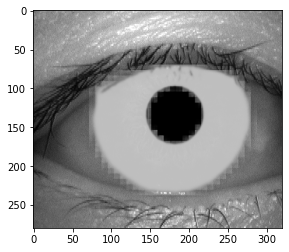

In [76]:
from PIL import Image

import numpy as np

path_img = "CASIA_v1" + os.sep + "001_1_1.bmp"
path_back = "CASIA_Segmented" + os.sep + "001_1_1.bmp"

image = Image.open(path_img)
background = Image.open(path_back)

background.paste(image, (0, 0), image)
plt.imshow(background, cmap='gray');

### 1. Aplicación de operadores morfológicos sobre la imagen segmentada

Este proceso consistirá en suavizar los bordes pixelados mediante operadores morfológicos como paso previo antes de aplicar el detector de Canny.

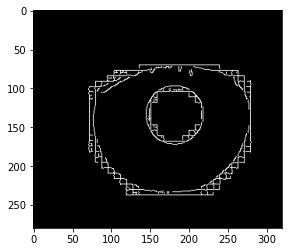

In [77]:
# Deteccion de bordes con Canny sin aplicar operadores morfológicos(suavizar los bordes)
path_img = "CASIA_Segmented" + os.sep + "001_1_1.bmp"
img = cv2.imread(path_img)
edges = cv2.Canny(img, 10, 255)
plt.imshow(edges, cmap='gray');

Para el suavizado de las muestras segmentadas se realizarán los siguientes pasos.

- Se binarizará la muestra
- Se aplicarán operadores morfológicos
- Se binarizará nuevamente.

In [78]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
(thresh, binRed) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY) # se binariza
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) # se aplica operadores morfológicos(vigilar iteraciones)
(thresh, binRed) = cv2.threshold(opening, 128, 255, cv2.THRESH_BINARY) # se binariza nuevamente

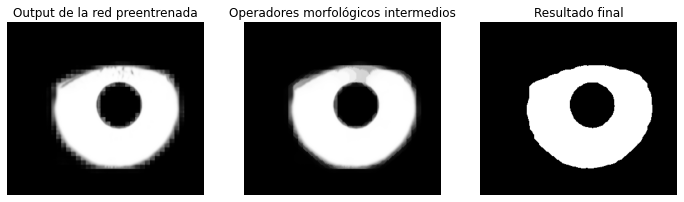

In [79]:
fig, axes = plt.subplots(1,3, figsize=(12,12))
axes[0].imshow(img,cmap='gray')
axes[0].set(title="Output de la red preentrenada")
axes[0].axis('off')
axes[1].imshow(opening,cmap='gray')
axes[1].set(title="Operadores morfológicos intermedios");
axes[1].axis('off')
axes[2].imshow(binRed,cmap='gray')
axes[2].set(title="Resultado final");
axes[2].axis('off');

In [80]:
# creamos un nuevo directorio para guardar las muestras segmentadas con mayor calidad
cv2.imwrite("CASIA_Segmented_v2"+ os.sep + "001_1_1.bmp", binRed)# guardamos muestra

True

Superponemos la imagen suavizada sobre la muestra, se observa que se ajusta mejor que el resultado anterior.

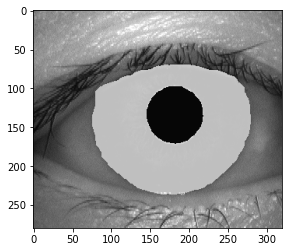

In [81]:
background = Image.open("CASIA_Segmented_v2"+ os.sep + "001_1_1.bmp")

background.paste(image, (0, 0), image)
plt.imshow(background);

Ahora aplicamos el detector de Canny nuevamente pero con la muestra suavizada.

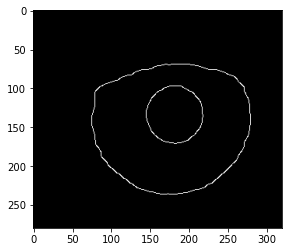

In [82]:
edges = cv2.Canny(binRed, 10, 255)
plt.imshow(edges, cmap='gray');

In [83]:
# creamos un nuevo directorio para guardar las muestras con los bordes detectados
cv2.imwrite("CASIA_Edge"+ os.sep + "001_1_1.bmp", edges)# guardamos muestra

True

Detecta a la perfección el iris, consiguiendo aislarlo del resto del ojo, pestañas incluídas, aunque estas se procesarán de una mejor manera posteriormente con el Hough de líneas.

### 2. Detección del iris
Se usará el método de Wildes el cuál se basa en la aplicación de la transformada de Hough adaptada para la detección de círculos (en lugar de líneas). Este enfoque es ampliamente usado debido a su precisión.

Este método implica tener que realizar 2 iteraciones(2 aplicaciones de Hough circular), una para localizar el borde límbico y la otra para localizar el borde pupilar. Como paso previo a aplicar Hough, se usará el detector de bordes de Canny.

### 2.1 Hough con OpenCV

Para el dataset de Casia, el radio del iris se encuentra en el rango de 90-150 píxeles, mientras que el radio de la pupila entre 28-75 píxeles

In [84]:
path_img = "CASIA_Edge" + os.sep + "001_1_1.bmp"

### Recortar iris

Una vez localizadas las coordenadas del iris ya se puede recortar de la muestra original, la parte correspondiente al iris.

Solución basada en: https://stackoverflow.com/questions/36911877/cropping-circle-from-image-using-opencv-python

### 2.2 Hough con Skimage

In [87]:
from skimage import data
from skimage.transform import (hough_line, hough_line_peaks, hough_circle, hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from matplotlib import cm

In [88]:
def draw_circles(img, cx, cy, radii):
    '''
    A partir de los centros y el radio detectados dibuja el iris sobre la imagen que se le
    pasa como parámetro.
    '''
#     image = gray2rgb(img) # convertimos a color
#     for center_y, center_x, radius in zip(cy, cx, radii):
#         circy, circx = circle_perimeter(center_y, center_x, radius)
# #         print(image[circy,circx])
#         image[circy, circx] = (0, 255, 0) # green
    image = img
    pupil = cv2.circle(image,(cx[0],cy[0]), radii[0], (255, 0, 0), 2)
    iris = cv2.circle(image,(cx[1],cy[1]), radii[1], (255, 0, 0), 2)
    return image

In [89]:
# muestra original
path_sample = "CASIA_v1" + os.sep + "001_1_1.bmp" 
# misma muestra pero con los bordes ya detectados con Canny
path_edged = "CASIA_Edge" + os.sep + "001_1_1.bmp"
sample = cv2.imread(path_sample,0)
gray_img = cv2.imread(path_edged, 0)
sample

array([[176, 166, 170, ..., 187, 180, 169],
       [170, 169, 173, ..., 185, 181, 179],
       [177, 165, 173, ..., 198, 187, 169],
       ...,
       [154, 155, 155, ..., 169, 178, 199],
       [159, 148, 154, ..., 170, 177, 192],
       [153, 154, 150, ..., 172, 171, 189]], dtype=uint8)

### Dibujar circunferencias exterior e interior correspondientes a los bordes límbico y pupilar

In [90]:
boundaries = [] # contiene los bordes límbico y pupilar
centers = [] # contiene centros y radio de la pupila

hough_radii = np.arange(20, 150, 2) # ajustar manualmente para que empiece desde un rango que incluya tanto al iris como a la pupila
hough_res = hough_circle(gray_img, hough_radii)

# ¡Ojo! Seleccionamos los círculos más prominentes, en este caso sabemos a priori que sólo puede haber 2, si subimos
# esa cantidad detectará círculos en zonas aleatorias
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=2) # total_num_peaks -> nro de círculos
x_pupil, x_iris = cx
y_pupil, y_iris = cy
radius_pupil, radius_iris = radii

print("center of pupil: ", (x_pupil,y_pupil))
print("radius of pupil: ", radius_pupil)
print("center of iris: ", (x_iris,y_iris))
print("radius of iris: ", radius_iris)
print("-------------------------")

iris_sample = draw_circles(sample, cx, cy, radii)
iris_edged = draw_circles(gray_img, cx, cy, radii) 

center of pupil:  (182, 134)
radius of pupil:  36
center of iris:  (177, 134)
radius of iris:  102
-------------------------


In [91]:
sample

array([[176, 166, 170, ..., 187, 180, 169],
       [170, 169, 173, ..., 185, 181, 179],
       [177, 165, 173, ..., 198, 187, 169],
       ...,
       [154, 155, 155, ..., 169, 178, 199],
       [159, 148, 154, ..., 170, 177, 192],
       [153, 154, 150, ..., 172, 171, 189]], dtype=uint8)

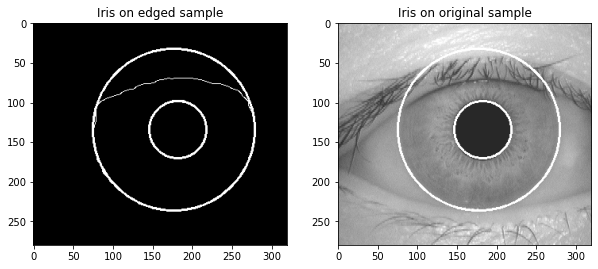

In [92]:
# bordes del iris 
boundaries.append(iris_sample)
# centros y radios de la pupila
centers.append([x_pupil, y_pupil, radius_pupil])

iris_edged = cv2.cvtColor(iris_edged, cv2.COLOR_GRAY2BGR)
iris_sample = cv2.cvtColor(iris_sample, cv2.COLOR_GRAY2BGR)
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(iris_edged)
axes[0].set(title="Iris on edged sample")
axes[1].imshow(iris_sample)
axes[1].set(title="Iris on original sample");

In [93]:
np.array_equal(sample,iris_sample)

False

In [94]:
boundaries
np.save("boundaries.npy",boundaries)

In [95]:
centers

[[182, 134, 36]]

### Recortar iris

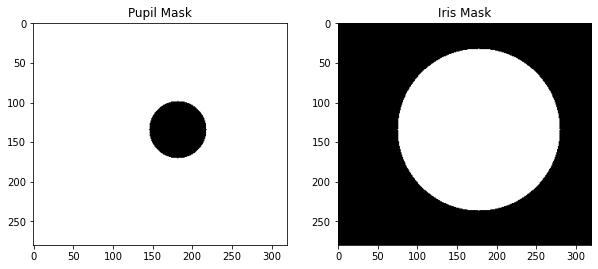

In [96]:
# creamos la máscara
height,width = gray_img.shape
mask = np.zeros((height,width), np.uint8)

# tenemos 2 círculos por lo que se dibujarán sobre la máscara
pupil_mask = cv2.circle(mask,(x_pupil,y_pupil),radius_pupil,(255,255,255),thickness=-1)
ret,pupil_mask = cv2.threshold(pupil_mask,127,255,cv2.THRESH_BINARY_INV) # de negro a blanco y viceversa

iris_mask = cv2.circle(mask,(x_iris,y_iris),radius_iris,(255,255,255),thickness=-1)

fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(pupil_mask, cmap='gray');
axes[0].set(title='Pupil Mask')
axes[1].imshow(iris_mask, cmap='gray');
axes[1].set(title='Iris Mask');

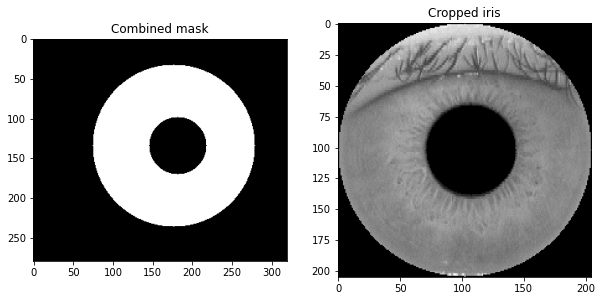

In [97]:
# combinamos ambas máscaras, es por ello que se ha binarizado la máscara de la pupila, para que "lo blanco" corresponda al iris
combined_mask = cv2.circle(iris_mask,(x_pupil,y_pupil),radius_pupil,(0,0,0),thickness=-1)

# muestra tal cual
path_img = "CASIA_v1" + os.sep + "001_1_1.bmp"
img = cv2.imread(path_img)

# copia de la muestra usando la máscara previa
masked_data = cv2.bitwise_and(img, img, mask=combined_mask)


# bianrizamos
_,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
#

# buscamos los contornos, los bordes de los círculos
(contours, hierarchy) = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#¿len(contours) > 1? porque debe encontrar los contornos de los bordes pupilar y límbico
contours = np.float32(contours)
x,y,w,h = cv2.boundingRect(contours[0])
crop = masked_data[y:y+h,x:x+w]
# cv2.imwrite("cropped.bmp", crop)


fig, axes = plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(combined_mask, cmap='gray')
axes[0].set(title='Combined mask')
axes[1].imshow(crop, cmap='gray')
axes[1].set(title='Cropped iris');

No me queda claro si la pupila se corresponde con la máscara calculada para ella, o sea si ha recortado tanto el borde exterior como el interior.

In [98]:
# creamos un nuevo directorio para guardar las muestras segmentadas con mayor calidad
os.mkdir("CASIA_Cropped")
cv2.imwrite("CASIA_Cropped"+ os.sep + "001_1_1.bmp", crop)# guardamos muestra

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: 'CASIA_Cropped'

### 3. Normalizar iris

Se convertirá el iris de coordenadas cartesianas a polares, es decir, se estirará la el iris, de modo que pasará a estar representado en forma de rectángulo.

### Primer intento

In [ ]:
source = cv2.imread("CASIA_Cropped"+ os.sep + "001_1_1.bmp", 0)
plt.imshow(source,'gray');

In [ ]:
from skimage.color import rgb2gray

#--- ensure image is of the type float ---
img = source.astype(np.float32)
width, height = img.shape

#--- the following holds the square root of the sum of squares of the image dimensions ---
#--- this is done so that the entire width/height of the original image is used to express the complete circular range of the resulting polar image ---
value = np.sqrt(((width/2.0)**2.0) + ((height/2.0)**2.0))
print(value)

polar_image = cv2.linearPolar(img,
                              (height/2, width/2),
                              value,
                              cv2.WARP_FILL_OUTLIERS)

polar_image = polar_image.astype(np.uint8)
plt.imshow(polar_image, 'gray')
plt.title("Polar Image");

### 2º Intento

Me he basado en el código del siguiente repositorio:

https://github.com/akshatapatel/Iris-Recognition/blob/master/IrisNormalization.py

In [ ]:
target = [img for img in boundaries]
print(target)
normalized=[]
cent=0
for img in target:
    #load pupil centers and radius of inner circles
    print(cent)
    center_x = centers[cent][0]
    center_y = centers[cent][1]
    radius_pupil=int(centers[cent][2])

    iris_radius = 53 # width of space between inner and outer boundary

    #define equally spaced interval to iterate over
    nsamples = 360
    samples = np.linspace(0,2*np.pi, nsamples)[:-1]
    polar = np.zeros((iris_radius, nsamples))
    for r in range(iris_radius):
        for theta in samples:
            #get x and y for values on inner boundary
            x = (r+radius_pupil)*np.cos(theta)+center_x
            y = (r+radius_pupil)*np.sin(theta)+center_y
            x=int(x)
            y=int(y)
            try:
            #convert coordinates
                polar[r][int((theta*nsamples)/(2*np.pi))] = img[y][x]
            except IndexError: #ignores values which lie out of bounds
                print("paso")
                pass
            continue
    res = cv2.resize(polar,(512,64))
    normalized.append(res)
    cent+=1
plt.imshow(normalized[0], "gray");


In [ ]:
np.max(boundaries[0][0])

La muestra normalizada proporciona una zona de la que se puede prescindir, es la correspondiente a las pestañas, por lo que se usará únicamente la primera mitad.

In [ ]:
h,w = normalized[0].shape # height, width
h,w

In [ ]:
# ajustamos verticalmente también ya que hay una pequeña zona que no aporta nada(~3)
roi = normalized[0][3:h, 0:int(512/2)]
plt.imshow(roi,"gray");

La ROI resultante da buenos resultados, pero se hará una última mejora que permita realzar el tejido membrano-muscular del iris, lo cual facilitará la posterior extracción de _features_.

Esto se hará variando el brillo y el contraste de la imágen mediante la ecualización del histograma.

In [ ]:
# roi = roi.astype(np.uint8) 
roi_enhanced = cv2.equalizeHist(roi)
plt.imshow(roi_enhanced,"gray");